# Diseño de Filtro Pasa-Banda para Arduino

Este notebook calcula los coeficientes de un filtro IIR pasa-banda centrado en 21 Hz ± 9 Hz para procesamiento en tiempo real en Arduino.

In [9]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PARÁMETROS DEL FILTRO
# ==============================================================================
fs = 2000  # Hz - Frecuencia de muestreo
f0 = 21    # Hz - Frecuencia central
BW = 9     # Hz - Ancho de banda (21 ± 9 Hz = 12-30 Hz)
Q = f0 / BW  # Q = 2.333

# ==============================================================================
# 2. COEFICIENTES REALES DEL ARDUINO (desde main.cpp)
# ==============================================================================
# Estos son los coeficientes Q15 actuales en el código Arduino:
# const int32_t b0_q15 = 456;
# const int32_t b1_q15 = 0;
# const int32_t b2_q15 = -456;
# const int32_t a1_q15 = -64482;
# const int32_t a2_q15 = 31855;

# Convertir de Q15 a float para análisis
def q15_to_float(q15_val):
    return q15_val / 32768.0

# Coeficientes en formato float (desde valores Q15 del Arduino)
b = np.array([
    q15_to_float(456),    # b0
    q15_to_float(0),      # b1
    q15_to_float(-456)    # b2
])

a = np.array([
    1.0,                  # a0 (siempre 1 normalizado)
    q15_to_float(-64482), # a1
    q15_to_float(31855)   # a2
])

# Conversión a Q15 (16-bit fixed point)
def float_to_q15(x):
    return int(np.round(x * 32768))

b_q15 = [float_to_q15(b[i]) for i in range(3)]
a_q15 = [float_to_q15(a[i]) for i in range(1, 3)]  # a[0]=1 es implícito

# ==============================================================================
# 3. RESULTADOS
# ==============================================================================
print("=" * 70)
print("FILTRO PASA-BANDA IIR - 21 Hz ± 9 Hz")
print("=" * 70)
print(f"Frecuencia de muestreo: {fs} Hz")
print(f"Frecuencia central: {f0} Hz")
print(f"Ancho de banda: {BW} Hz (rango: {f0-9} Hz - {f0+9} Hz)")
print(f"Factor de calidad Q: {Q:.3f}")
print("\n" + "-" * 70)
print("COEFICIENTES FLOAT (desde Q15 del Arduino):")
print("-" * 70)
print(f"b = [{b[0]:.6f}, {b[1]:.6f}, {b[2]:.6f}]")
print(f"a = [{a[0]:.6f}, {a[1]:.6f}, {a[2]:.6f}]")
print("\n" + "-" * 70)
print("COEFICIENTES Q15 EN EL ARDUINO (main.cpp):")
print("-" * 70)
print(f"const int32_t b0_q15 = {b_q15[0]};      // {b[0]:.6f}")
print(f"const int32_t b1_q15 = {b_q15[1]};      // {b[1]:.6f}")
print(f"const int32_t b2_q15 = {b_q15[2]};     // {b[2]:.6f}")
print(f"const int32_t a1_q15 = {a_q15[0]};   // {a[1]:.6f}")
print(f"const int32_t a2_q15 = {a_q15[1]};    // {a[2]:.6f}")
print("\n" + "-" * 70)
print("JUSTIFICACIÓN DEL DISEÑO:")
print("-" * 70)
print(f"• Frecuencia central 21 Hz: Frecuencia característica de la señal objetivo")
print(f"• Ancho de banda ±9 Hz: Balance entre selectividad y tolerancia a variaciones")
print(f"• Q = {Q:.3f}: Factor de calidad moderado para evitar resonancias excesivas")
print(f"• Formato Q15: Precisión de 15 bits fraccionarios, rango ±1.0, óptimo para Arduino")
print("=" * 70)

FILTRO PASA-BANDA IIR - 21 Hz ± 9 Hz
Frecuencia de muestreo: 2000 Hz
Frecuencia central: 21 Hz
Ancho de banda: 9 Hz (rango: 12 Hz - 30 Hz)
Factor de calidad Q: 2.333

----------------------------------------------------------------------
COEFICIENTES FLOAT (desde Q15 del Arduino):
----------------------------------------------------------------------
b = [0.013916, 0.000000, -0.013916]
a = [1.000000, -1.967834, 0.972137]

----------------------------------------------------------------------
COEFICIENTES Q15 EN EL ARDUINO (main.cpp):
----------------------------------------------------------------------
const int32_t b0_q15 = 456;      // 0.013916
const int32_t b1_q15 = 0;      // 0.000000
const int32_t b2_q15 = -456;     // -0.013916
const int32_t a1_q15 = -64482;   // -1.967834
const int32_t a2_q15 = 31855;    // 0.972137

----------------------------------------------------------------------
JUSTIFICACIÓN DEL DISEÑO:
------------------------------------------------------------------

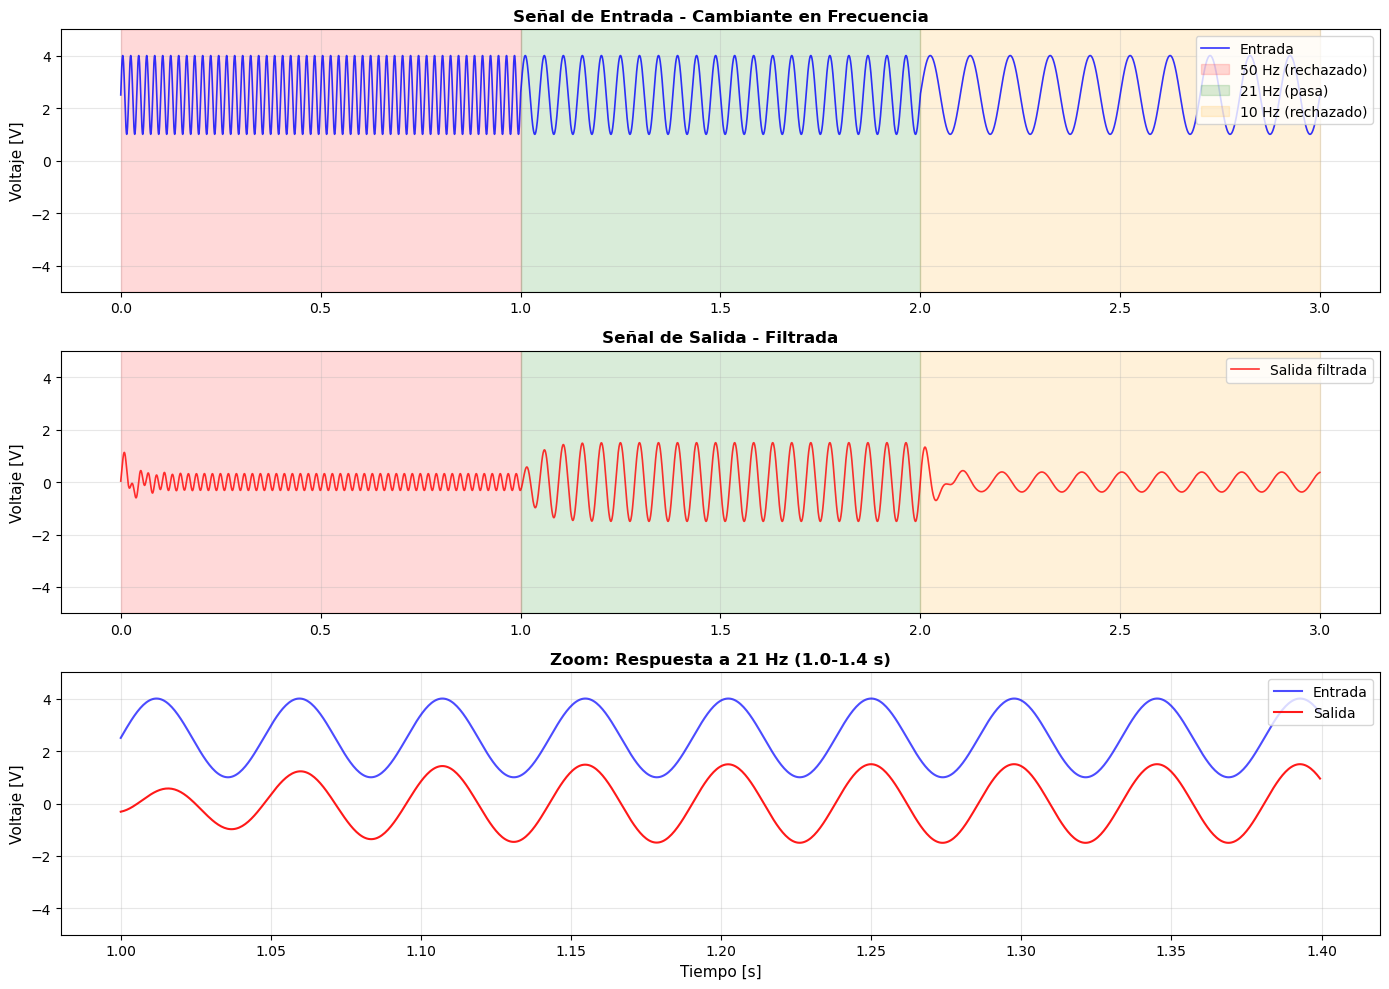


ANÁLISIS DE LA SEÑAL FILTRADA

Segmento 1: 50 Hz (0-1s)
  Amplitud entrada:  1.500 V
  Amplitud salida:   0.320 V
  Atenuación:        -13.41 dB

Segmento 2: 21 Hz (1-2s)
  Amplitud entrada:  1.500 V
  Amplitud salida:   1.498 V
  Atenuación:        -0.01 dB

Segmento 3: 10 Hz (2-3s)
  Amplitud entrada:  1.500 V
  Amplitud salida:   0.383 V
  Atenuación:        -11.86 dB


In [10]:
# ==============================================================================
# EJEMPLO: SEÑAL SINTÉTICA CAMBIANTE
# ==============================================================================
# Simulación con una señal que cambia de frecuencia en el tiempo

duration = 3.0  # segundos
t = np.arange(0, duration, 1/fs)

# Crear señal sintética con cambios de frecuencia
signal_input = np.zeros_like(t)

# Segmento 1 (0-1s): 50 Hz (fuera de banda - debe ser rechazado)
mask1 = t < 1.0
signal_input[mask1] = 1.5 * np.sin(2 * np.pi * 50 * t[mask1])

# Segmento 2 (1-2s): 21 Hz (en banda - debe pasar)
mask2 = (t >= 1.0) & (t < 2.0)
signal_input[mask2] = 1.5 * np.sin(2 * np.pi * 21 * t[mask2])

# Segmento 3 (2-3s): 10 Hz (fuera de banda - debe ser rechazado)
mask3 = t >= 2.0
signal_input[mask3] = 1.5 * np.sin(2 * np.pi * 10 * t[mask3])

# Aplicar offset DC (simular ADC de 0-5V centrado en 2.5V)
signal_input = signal_input + 2.5

# Aplicar filtro
signal_output = signal.lfilter(b, a, signal_input)

# Graficar
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Señal completa
axes[0].plot(t, signal_input, 'b-', linewidth=1.2, alpha=0.8, label='Entrada')
axes[0].axvspan(0, 1, alpha=0.15, color='red', label='50 Hz (rechazado)')
axes[0].axvspan(1, 2, alpha=0.15, color='green', label='21 Hz (pasa)')
axes[0].axvspan(2, 3, alpha=0.15, color='orange', label='10 Hz (rechazado)')
axes[0].set_ylabel('Voltaje [V]', fontsize=11)
axes[0].set_title('Señal de Entrada - Cambiante en Frecuencia', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([-5, 5])

axes[1].plot(t, signal_output, 'r-', linewidth=1.2, alpha=0.8, label='Salida filtrada')
axes[1].axvspan(0, 1, alpha=0.15, color='red')
axes[1].axvspan(1, 2, alpha=0.15, color='green')
axes[1].axvspan(2, 3, alpha=0.15, color='orange')
axes[1].set_ylabel('Voltaje [V]', fontsize=11)
axes[1].set_title('Señal de Salida - Filtrada', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-5, 5])

# Zoom en transición 21 Hz (región interesante)
zoom_start = 1.0
zoom_end = 1.4
mask_zoom = (t >= zoom_start) & (t <= zoom_end)
axes[2].plot(t[mask_zoom], signal_input[mask_zoom], 'b-', linewidth=1.5, alpha=0.7, label='Entrada')
axes[2].plot(t[mask_zoom], signal_output[mask_zoom], 'r-', linewidth=1.5, alpha=0.9, label='Salida')
axes[2].set_xlabel('Tiempo [s]', fontsize=11)
axes[2].set_ylabel('Voltaje [V]', fontsize=11)
axes[2].set_title(f'Zoom: Respuesta a 21 Hz ({zoom_start}-{zoom_end} s)', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([-5, 5])

plt.tight_layout()
plt.show()

# Análisis cuantitativo
print("\n" + "=" * 70)
print("ANÁLISIS DE LA SEÑAL FILTRADA")
print("=" * 70)

for i, (name, mask, freq) in enumerate([
    ("50 Hz (0-1s)", mask1, 50),
    ("21 Hz (1-2s)", mask2, 21),
    ("10 Hz (2-3s)", mask3, 10)
]):
    # Evitar transitorio inicial (primeros 200ms de cada segmento)
    mask_steady = mask.copy()
    start_idx = np.where(mask)[0][0]
    mask_steady[start_idx:start_idx+int(0.2*fs)] = False
    
    if np.sum(mask_steady) > 0:
        amp_in = (signal_input[mask_steady].max() - signal_input[mask_steady].min()) / 2
        amp_out = (signal_output[mask_steady].max() - signal_output[mask_steady].min()) / 2
        attenuation = 20 * np.log10(amp_out / amp_in) if amp_in > 0 else -np.inf
        
        print(f"\nSegmento {i+1}: {name}")
        print(f"  Amplitud entrada:  {amp_in:.3f} V")
        print(f"  Amplitud salida:   {amp_out:.3f} V")
        print(f"  Atenuación:        {attenuation:.2f} dB")

print("=" * 70)

## Filtro de Hilbert para Transformada Analítica

El filtro de Hilbert introduce un desfase de 90° para crear la componente en cuadratura, permitiendo calcular la envolvente y fase instantánea.

In [11]:
# ==============================================================================
# COEFICIENTES REALES DEL FILTRO DE HILBERT (desde main.cpp)
# ==============================================================================
# Filtro FIR de 15 taps que introduce desfase de 90° para la transformada de Hilbert

hilbert_taps = 15

# Coeficientes Q15 actuales en el Arduino (desde main.cpp líneas 28-30):
# const int16_t hilbert_coeffs[HILBERT_TAPS] = {
#   -328, 0, -984, 0, -2621, 0, -6554, 0, 6554, 0, 2621, 0, 984, 0, 328
# };

hilbert_coeffs_q15 = [-328, 0, -984, 0, -2621, 0, -6554, 0, 6554, 0, 2621, 0, 984, 0, 328]

# Convertir de Q15 a float para análisis
hilbert_coeffs_float = np.array([q15_to_float(c) for c in hilbert_coeffs_q15])

print("=" * 70)
print("FILTRO DE HILBERT FIR - 15 TAPS")
print("=" * 70)
print(f"Número de taps: {hilbert_taps}")
print(f"\n" + "-" * 70)
print("COEFICIENTES FLOAT (desde Q15 del Arduino):")
print("-" * 70)
for i, c in enumerate(hilbert_coeffs_float):
    print(f"  h[{i:2d}] = {c:9.6f}  (Q15: {hilbert_coeffs_q15[i]:6d})")

print(f"\n" + "-" * 70)
print("COEFICIENTES Q15 EN EL ARDUINO (main.cpp):")
print("-" * 70)
print("#define HILBERT_TAPS 15")
print("const int16_t hilbert_coeffs[HILBERT_TAPS] = {")
for i in range(0, len(hilbert_coeffs_q15), 5):
    line = "  " + ", ".join([f"{c:6d}" for c in hilbert_coeffs_q15[i:min(i+5, len(hilbert_coeffs_q15))]])
    if i + 5 < len(hilbert_coeffs_q15):
        line += ","
    print(line)
print("};")

print("\n" + "-" * 70)
print("JUSTIFICACIÓN DEL DISEÑO:")
print("-" * 70)
print(f"• Simetría antisimétrica: Coeficientes pares son cero, impares alternados")
print(f"• Respuesta de fase: Introduce desfase de -90° en la banda de paso")
print(f"• 15 taps: Balance entre precisión del desfase y carga computacional")
print(f"• Retardo constante: (N-1)/2 = {(hilbert_taps-1)/2:.1f} muestras = {(hilbert_taps-1)/2*1000/fs:.2f} ms")
print(f"• Formato Q15: int16_t para reducir memoria (15 taps × 2 bytes = 30 bytes)")
print("=" * 70)

FILTRO DE HILBERT FIR - 15 TAPS
Número de taps: 15

----------------------------------------------------------------------
COEFICIENTES FLOAT (desde Q15 del Arduino):
----------------------------------------------------------------------
  h[ 0] = -0.010010  (Q15:   -328)
  h[ 1] =  0.000000  (Q15:      0)
  h[ 2] = -0.030029  (Q15:   -984)
  h[ 3] =  0.000000  (Q15:      0)
  h[ 4] = -0.079987  (Q15:  -2621)
  h[ 5] =  0.000000  (Q15:      0)
  h[ 6] = -0.200012  (Q15:  -6554)
  h[ 7] =  0.000000  (Q15:      0)
  h[ 8] =  0.200012  (Q15:   6554)
  h[ 9] =  0.000000  (Q15:      0)
  h[10] =  0.079987  (Q15:   2621)
  h[11] =  0.000000  (Q15:      0)
  h[12] =  0.030029  (Q15:    984)
  h[13] =  0.000000  (Q15:      0)
  h[14] =  0.010010  (Q15:    328)

----------------------------------------------------------------------
COEFICIENTES Q15 EN EL ARDUINO (main.cpp):
----------------------------------------------------------------------
#define HILBERT_TAPS 15
const int16_t hilbert_coeff

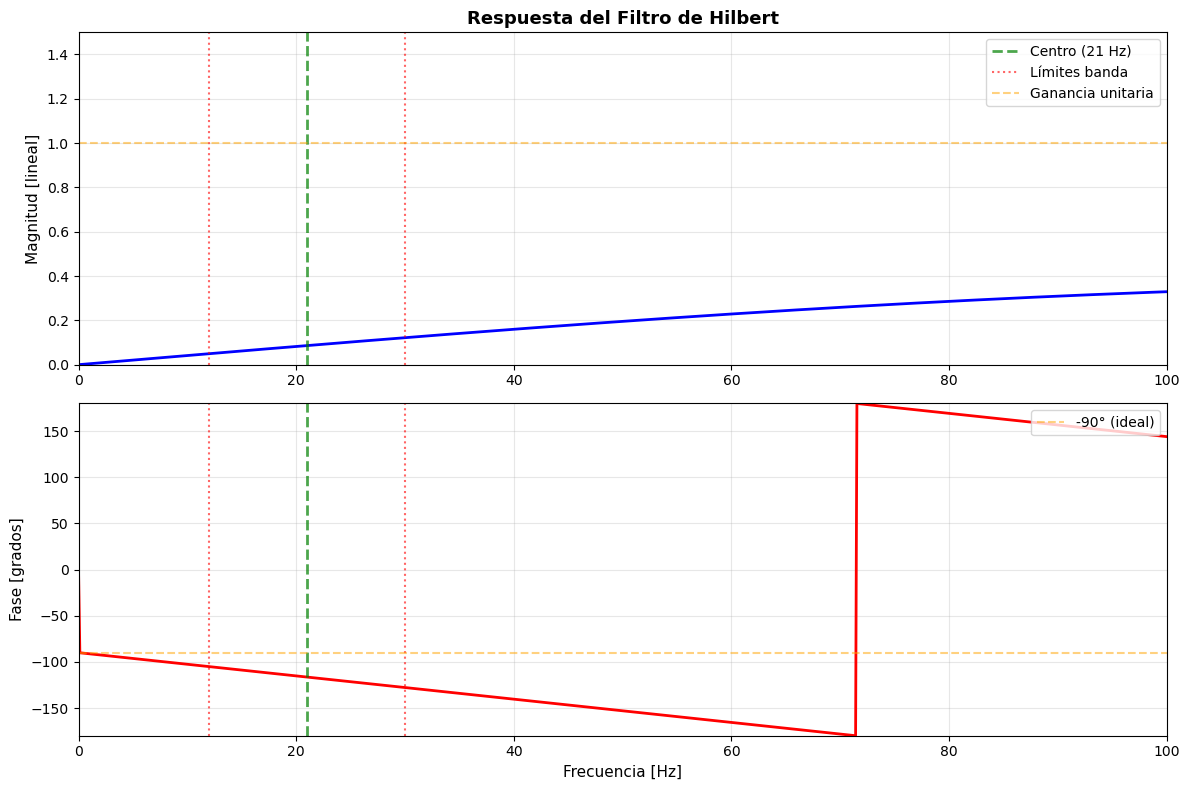


Respuesta a 21 Hz:
  Magnitud: 0.0862
  Fase:     -116.46° (ideal: -90°)
  Error:    -26.46°


In [12]:
# ==============================================================================
# RESPUESTA EN FRECUENCIA DEL FILTRO DE HILBERT
# ==============================================================================

w_h, h_h = signal.freqz(hilbert_coeffs_float, 1, worN=8192, fs=fs)
mag_h = np.abs(h_h)
phase_h = np.angle(h_h, deg=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitud
ax1.plot(w_h, mag_h, 'b-', linewidth=2)
ax1.axvline(21, color='g', linestyle='--', alpha=0.7, linewidth=2, label='Centro (21 Hz)')
ax1.axvline(12, color='r', linestyle=':', alpha=0.6, linewidth=1.5, label='Límites banda')
ax1.axvline(30, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax1.axhline(1.0, color='orange', linestyle='--', alpha=0.5, label='Ganancia unitaria')
ax1.set_ylabel('Magnitud [lineal]', fontsize=11)
ax1.set_title('Respuesta del Filtro de Hilbert', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=10)
ax1.set_xlim([0, 100])
ax1.set_ylim([0, 1.5])

# Fase (debe ser cercana a -90° en la banda de paso)
ax2.plot(w_h, phase_h, 'r-', linewidth=2)
ax2.axvline(21, color='g', linestyle='--', alpha=0.7, linewidth=2)
ax2.axvline(12, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax2.axvline(30, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax2.axhline(-90, color='orange', linestyle='--', alpha=0.5, label='-90° (ideal)')
ax2.set_xlabel('Frecuencia [Hz]', fontsize=11)
ax2.set_ylabel('Fase [grados]', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_xlim([0, 100])
ax2.set_ylim([-180, 180])

plt.tight_layout()
plt.show()

# Verificar desfase en 21 Hz
w_test = 2 * np.pi * 21 / fs
_, h_test = signal.freqz(hilbert_coeffs_float, 1, worN=[w_test])
phase_21 = np.angle(h_test[0], deg=True)
mag_21 = np.abs(h_test[0])

print(f"\nRespuesta a 21 Hz:")
print(f"  Magnitud: {mag_21:.4f}")
print(f"  Fase:     {phase_21:.2f}° (ideal: -90°)")
print(f"  Error:    {phase_21 + 90:.2f}°")

In [13]:
# ==============================================================================
# PARÁMETROS DE DETECCIÓN Y TIMING (desde main.cpp)
# ==============================================================================
# Estos son los parámetros reales utilizados en el Arduino para la detección de picos

print("=" * 70)
print("PARÁMETROS DE DETECCIÓN EN EL ARDUINO")
print("=" * 70)

# Umbrales de detección (líneas 36-37 en main.cpp)
MAGNITUDE_THRESHOLD_Q15 = 50  # En unidades de señal pre-shift (50L << 15)
PHASE_THRESHOLD = 2730        # En unidades de fase CORDIC (rango ±32768)

# Convertir umbral de magnitud a unidades reales
# En el código: const int32_t MAGNITUDE_THRESHOLD = 50L << Q15_SHIFT;
# Esto significa: 50 * 2^15 = 50 * 32768 = 1,638,400 en unidades Q15
magnitude_threshold_shifted = MAGNITUDE_THRESHOLD_Q15 * 32768

# Convertir umbral de fase a grados
# CORDIC usa ±32768 para representar ±180°
phase_threshold_deg = (PHASE_THRESHOLD / 32768) * 180

print("\n" + "-" * 70)
print("1. UMBRAL DE MAGNITUD:")
print("-" * 70)
print(f"   const int32_t MAGNITUDE_THRESHOLD = {MAGNITUDE_THRESHOLD_Q15}L << Q15_SHIFT;")
print(f"   Valor efectivo: {magnitude_threshold_shifted}")
print(f"   ")
print(f"   JUSTIFICACIÓN:")
print(f"   • Evita falsos positivos por ruido de baja amplitud")
print(f"   • Valor de 50 (en escala pre-shift) ajustado experimentalmente")
print(f"   • Balance entre sensibilidad y rechazo de ruido")

print("\n" + "-" * 70)
print("2. UMBRAL DE FASE:")
print("-" * 70)
print(f"   const int16_t PHASE_THRESHOLD = {PHASE_THRESHOLD};")
print(f"   Equivalente: ±{phase_threshold_deg:.2f}° alrededor de ±180°")
print(f"   Ventana de detección: {180-phase_threshold_deg:.2f}° a 180° (y {-180+phase_threshold_deg:.2f}° a -180°)")
print(f"   ")
print(f"   JUSTIFICACIÓN:")
print(f"   • Detecta picos negativos (fase ≈ ±180°)")
print(f"   • Ventana de ±{phase_threshold_deg:.2f}° tolera pequeñas variaciones")
print(f"   • Evita detecciones múltiples por ruido de fase")

# Parámetros de timing (líneas 38-42 en main.cpp)
PERIOD_21HZ_MS = 48
FILTER_DELAY_MS = 10
PHASE_ADJUST_MS = -1
PREDICTION_DELAY_MS = PERIOD_21HZ_MS - FILTER_DELAY_MS
PREDICTION_DELAY_SAMPLES = PREDICTION_DELAY_MS * 2  # fs = 2000 Hz → 2 samples/ms

print("\n" + "-" * 70)
print("3. PARÁMETROS DE TIMING Y PREDICCIÓN:")
print("-" * 70)
print(f"   #define PERIOD_21HZ_MS {PERIOD_21HZ_MS}")
print(f"   • Período de la señal: {PERIOD_21HZ_MS} ms (1000/{PERIOD_21HZ_MS:.0f} = {1000/PERIOD_21HZ_MS:.2f} Hz)")
print(f"   ")
print(f"   #define FILTER_DELAY_MS {FILTER_DELAY_MS}")
print(f"   • Retardo estimado de los filtros IIR + Hilbert: {FILTER_DELAY_MS} ms")
print(f"   • Equivalente a {FILTER_DELAY_MS * 2} muestras a 2000 Hz")
print(f"   ")
print(f"   #define PHASE_ADJUST_MS {PHASE_ADJUST_MS}")
print(f"   • Ajuste fino de fase: {PHASE_ADJUST_MS} ms")
print(f"   • Usado para compensación adicional si es necesario")
print(f"   ")
print(f"   #define PREDICTION_DELAY_MS (PERIOD_21HZ_MS - FILTER_DELAY_MS)")
print(f"   • Retardo de predicción: {PREDICTION_DELAY_MS} ms")
print(f"   • Lógica: detectar el pico, esperar hasta el SIGUIENTE pico")
print(f"   ")
print(f"   #define PREDICTION_DELAY_SAMPLES (PREDICTION_DELAY_MS * 2)")
print(f"   • Retardo en muestras: {PREDICTION_DELAY_SAMPLES} samples")
print(f"   ")
print(f"   JUSTIFICACIÓN:")
print(f"   • Predicción del siguiente pico basada en periodicidad de 21 Hz")
print(f"   • Compensa retardo de filtros ({FILTER_DELAY_MS} ms)")
print(f"   • Permite sincronización precisa con el pico siguiente")

# Control de pulsos (líneas 44-51 en main.cpp)
PULSE_DURATION = 2  # ms
REFRACTORY_COUNTDOWN = 20  # samples

print("\n" + "-" * 70)
print("4. CONTROL DE PULSOS:")
print("-" * 70)
print(f"   const unsigned long PULSE_DURATION = {PULSE_DURATION};")
print(f"   • Duración del pulso de salida: {PULSE_DURATION} ms")
print(f"   ")
print(f"   refractoryCountdown = {REFRACTORY_COUNTDOWN};  // (línea 263)")
print(f"   • Período refractario: {REFRACTORY_COUNTDOWN} muestras = {REFRACTORY_COUNTDOWN/2} ms")
print(f"   • Evita detecciones múltiples del mismo pico")
print(f"   ")
print(f"   #define PULSE_QUEUE_SIZE 4")
print(f"   • Cola de pulsos pendientes: capacidad para 4 detecciones")
print(f"   • Gestiona múltiples detecciones en ráfaga sin perder eventos")

print("\n" + "-" * 70)
print("5. LÓGICA DE DETECCIÓN (línea 234-235):")
print("-" * 70)
print("   bool isPeak = (envelope > MAGNITUDE_THRESHOLD) &&")
print("                 ((phase > (32768 - PHASE_THRESHOLD)) || ")
print("                  (phase < (-32768 + PHASE_THRESHOLD)));")
print(f"   ")
print(f"   • Condición 1: Magnitud > umbral ({MAGNITUDE_THRESHOLD_Q15} << 15)")
print(f"   • Condición 2: Fase en ventana de ±180° (±{phase_threshold_deg:.2f}° de tolerancia)")
print(f"   • Ambas condiciones deben cumplirse simultáneamente")

print("=" * 70)

PARÁMETROS DE DETECCIÓN EN EL ARDUINO

----------------------------------------------------------------------
1. UMBRAL DE MAGNITUD:
----------------------------------------------------------------------
   const int32_t MAGNITUDE_THRESHOLD = 50L << Q15_SHIFT;
   Valor efectivo: 1638400
   
   JUSTIFICACIÓN:
   • Evita falsos positivos por ruido de baja amplitud
   • Valor de 50 (en escala pre-shift) ajustado experimentalmente
   • Balance entre sensibilidad y rechazo de ruido

----------------------------------------------------------------------
2. UMBRAL DE FASE:
----------------------------------------------------------------------
   const int16_t PHASE_THRESHOLD = 2730;
   Equivalente: ±15.00° alrededor de ±180°
   Ventana de detección: 165.00° a 180° (y -165.00° a -180°)
   
   JUSTIFICACIÓN:
   • Detecta picos negativos (fase ≈ ±180°)
   • Ventana de ±15.00° tolera pequeñas variaciones
   • Evita detecciones múltiples por ruido de fase

-----------------------------------------

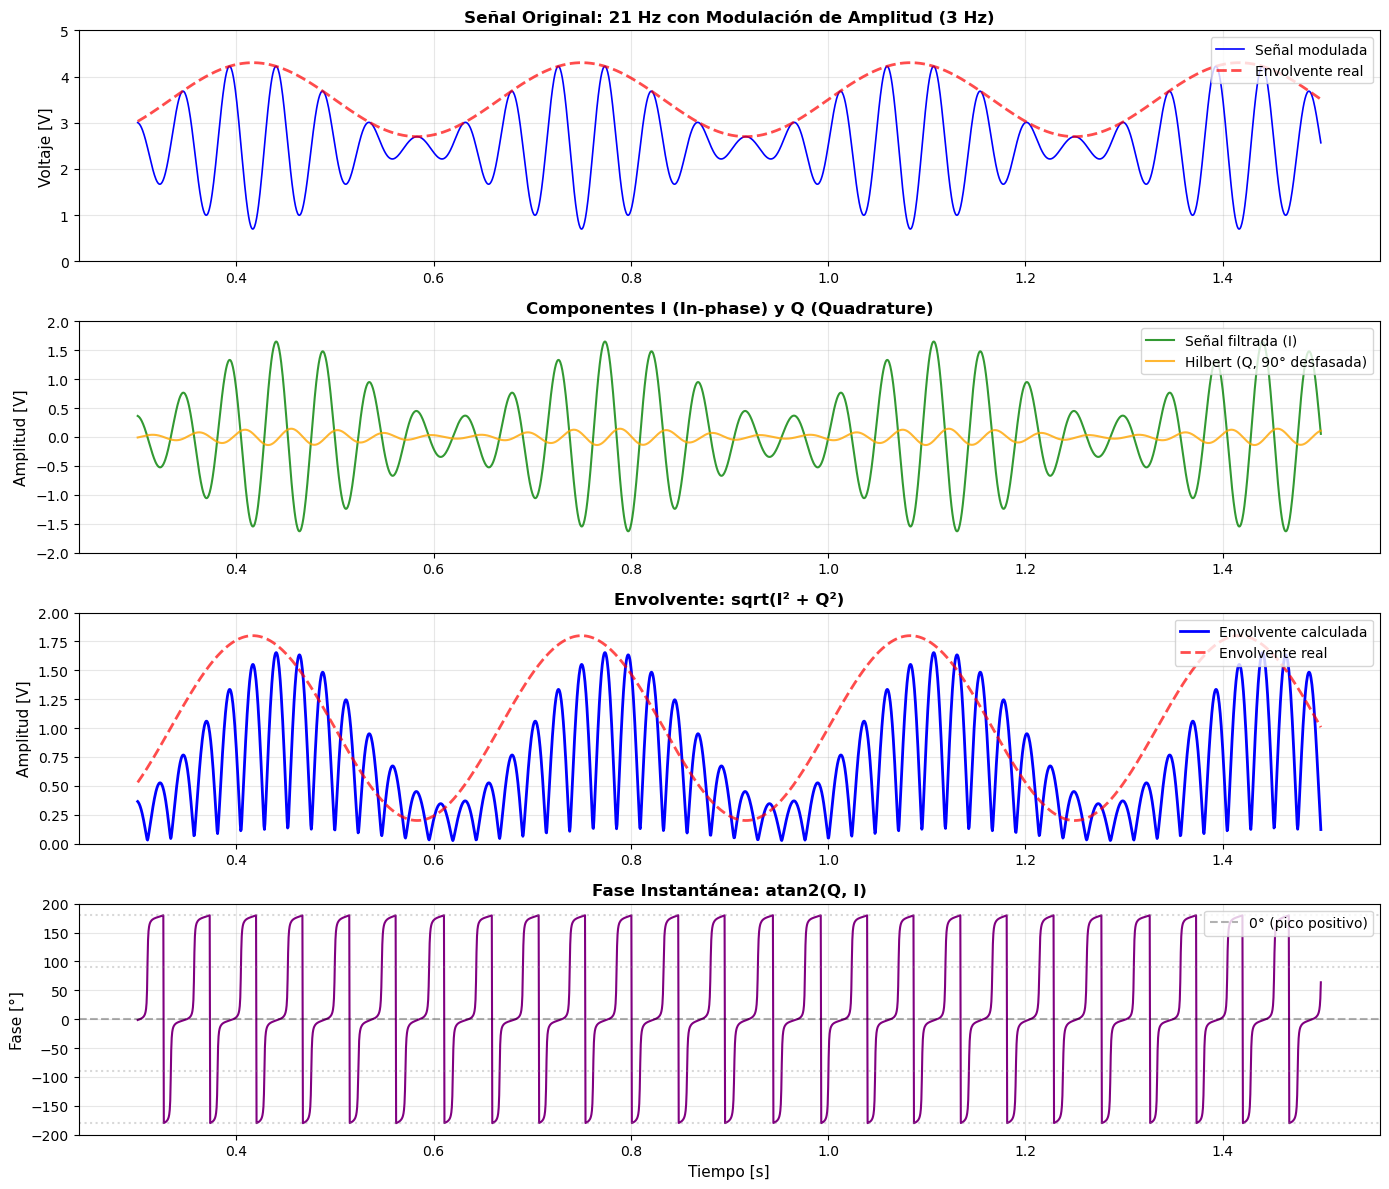


ANÁLISIS DE ENVOLVENTE Y FASE

Envolvente:
  Error medio absoluto: 0.3962 V
  Correlación con real: 0.5716

Fase instantánea:
  Rango: [-180.0°, 180.0°]
  Media: 24.2°
  Desv. estándar: 118.7°


In [14]:
# ==============================================================================
# CÁLCULO DE ENVOLVENTE Y FASE INSTANTÁNEA
# ==============================================================================
# Demostración del proceso completo: filtrado → Hilbert → envolvente + fase

# Señal de prueba: 21 Hz con modulación de amplitud
duration_demo = 2.0
t_demo = np.arange(0, duration_demo, 1/fs)

# Señal modulada: amplitud varía lentamente (3 Hz)
carrier_freq = 21  # Hz
modulation_freq = 3  # Hz
amplitude_carrier = 1.0
amplitude_mod = 0.8

# Señal: A(t) * sin(2πf_c*t), donde A(t) = 1 + 0.8*sin(2πf_m*t)
envelope_true = amplitude_carrier * (1 + amplitude_mod * np.sin(2 * np.pi * modulation_freq * t_demo))
signal_modulated = envelope_true * np.sin(2 * np.pi * carrier_freq * t_demo)
signal_modulated = signal_modulated + 2.5  # Agregar offset DC

# Paso 1: Aplicar filtro pasa-banda
signal_filtered = signal.lfilter(b, a, signal_modulated)

# Paso 2: Aplicar transformada de Hilbert
signal_hilbert = signal.lfilter(hilbert_coeffs_float, 1, signal_filtered)

# Paso 3: Calcular envolvente (magnitud de señal analítica)
# Remover offset DC para el cálculo
signal_filtered_ac = signal_filtered - np.mean(signal_filtered)
signal_hilbert_ac = signal_hilbert - np.mean(signal_hilbert)

envelope_calculated = np.sqrt(signal_filtered_ac**2 + signal_hilbert_ac**2)

# Paso 4: Calcular fase instantánea
phase_calculated = np.arctan2(signal_hilbert_ac, signal_filtered_ac)
phase_calculated_deg = np.rad2deg(phase_calculated)

# Graficar
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Región de interés (después de transitorios)
start_plot = int(0.3 * fs)
end_plot = int(1.5 * fs)

# 1. Señal original modulada
axes[0].plot(t_demo[start_plot:end_plot], signal_modulated[start_plot:end_plot], 'b-', linewidth=1.2, label='Señal modulada')
axes[0].plot(t_demo[start_plot:end_plot], envelope_true[start_plot:end_plot] + 2.5, 'r--', linewidth=2, alpha=0.7, label='Envolvente real')
axes[0].set_ylabel('Voltaje [V]', fontsize=11)
axes[0].set_title('Señal Original: 21 Hz con Modulación de Amplitud (3 Hz)', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 5])

# 2. Señal filtrada y su transformada de Hilbert
axes[1].plot(t_demo[start_plot:end_plot], signal_filtered_ac[start_plot:end_plot], 'g-', linewidth=1.5, alpha=0.8, label='Señal filtrada (I)')
axes[1].plot(t_demo[start_plot:end_plot], signal_hilbert_ac[start_plot:end_plot], 'orange', linewidth=1.5, alpha=0.8, label='Hilbert (Q, 90° desfasada)')
axes[1].set_ylabel('Amplitud [V]', fontsize=11)
axes[1].set_title('Componentes I (In-phase) y Q (Quadrature)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([-2, 2])

# 3. Envolvente calculada vs real
axes[2].plot(t_demo[start_plot:end_plot], envelope_calculated[start_plot:end_plot], 'b-', linewidth=2, label='Envolvente calculada')
axes[2].plot(t_demo[start_plot:end_plot], envelope_true[start_plot:end_plot], 'r--', linewidth=2, alpha=0.7, label='Envolvente real')
axes[2].set_ylabel('Amplitud [V]', fontsize=11)
axes[2].set_title('Envolvente: sqrt(I² + Q²)', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 2])

# 4. Fase instantánea
axes[3].plot(t_demo[start_plot:end_plot], phase_calculated_deg[start_plot:end_plot], 'purple', linewidth=1.5)
axes[3].axhline(0, color='k', linestyle='--', alpha=0.3, label='0° (pico positivo)')
axes[3].axhline(90, color='gray', linestyle=':', alpha=0.3)
axes[3].axhline(-90, color='gray', linestyle=':', alpha=0.3)
axes[3].axhline(180, color='gray', linestyle=':', alpha=0.3)
axes[3].axhline(-180, color='gray', linestyle=':', alpha=0.3)
axes[3].set_xlabel('Tiempo [s]', fontsize=11)
axes[3].set_ylabel('Fase [°]', fontsize=11)
axes[3].set_title('Fase Instantánea: atan2(Q, I)', fontsize=12, fontweight='bold')
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)
axes[3].set_ylim([-200, 200])

plt.tight_layout()
plt.show()

# Análisis cuantitativo
print("\n" + "=" * 70)
print("ANÁLISIS DE ENVOLVENTE Y FASE")
print("=" * 70)

# Comparar envolvente en región estable
stable_region = slice(int(0.5*fs), int(1.0*fs))
env_error = np.mean(np.abs(envelope_calculated[stable_region] - envelope_true[stable_region]))
env_corr = np.corrcoef(envelope_calculated[stable_region], envelope_true[stable_region])[0, 1]

print(f"\nEnvolvente:")
print(f"  Error medio absoluto: {env_error:.4f} V")
print(f"  Correlación con real: {env_corr:.4f}")

print(f"\nFase instantánea:")
print(f"  Rango: [{phase_calculated_deg.min():.1f}°, {phase_calculated_deg.max():.1f}°]")
print(f"  Media: {phase_calculated_deg.mean():.1f}°")
print(f"  Desv. estándar: {phase_calculated_deg.std():.1f}°")

print("=" * 70)

C:\Users\emanu\AppData\Local\Temp\ipykernel_57200\3522835845.py:5: RuntimeWarning: divide by zero encountered in log10
  mag_db = 20 * np.log10(np.abs(h))


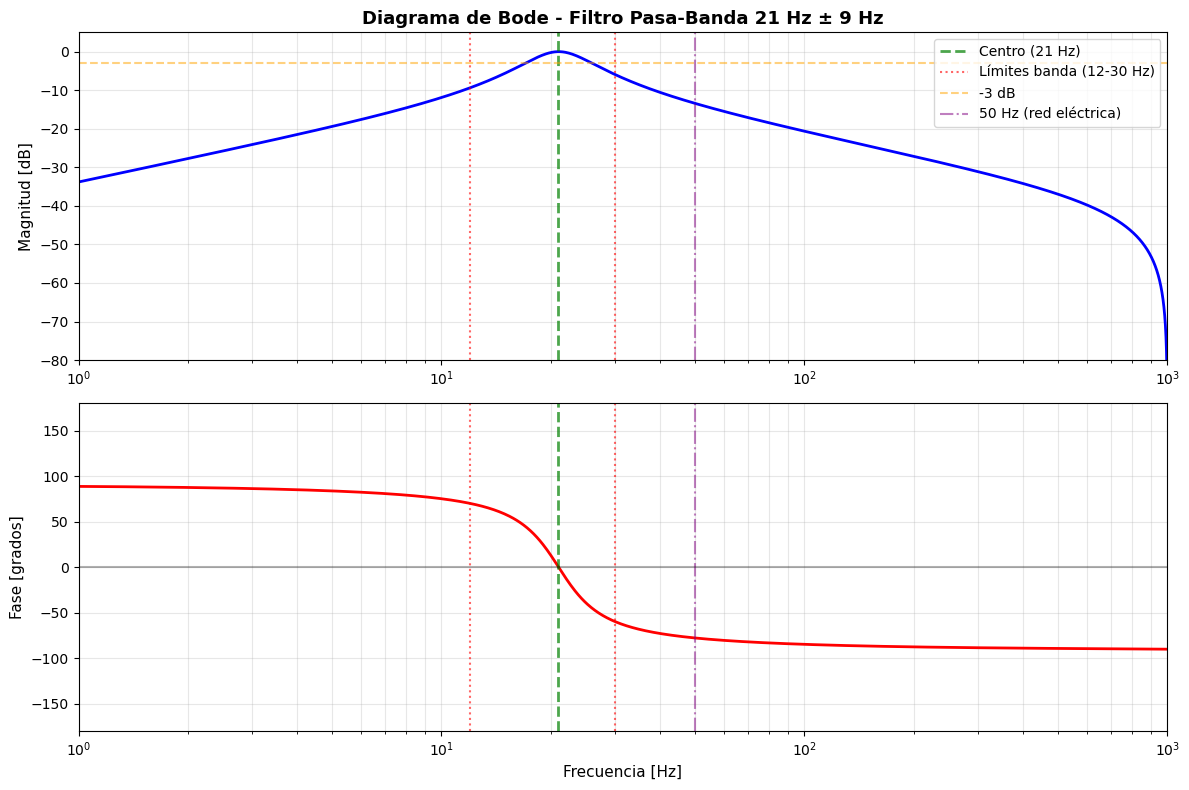


RESPUESTA DEL FILTRO EN FRECUENCIAS CLAVE
Freq [Hz]    Magnitud [dB]      Fase [°]       
----------------------------------------------------------------------
10                    -11.91           75.27
12                     -9.37           70.10 ← Límite banda
15                     -5.56           58.16
18                     -1.87           36.15
21                     -0.01            0.40 ← CENTRO
24                     -1.42          -31.78
27                     -3.80          -49.74
30                     -5.90          -59.49 ← Límite banda
50                    -13.44          -77.69
100                   -20.64          -84.67


In [15]:
# ==============================================================================
# DIAGRAMA DE BODE
# ==============================================================================
w, h = signal.freqz(b, a, worN=8192, fs=fs)
mag_db = 20 * np.log10(np.abs(h))
phase_deg = np.angle(h, deg=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitud
ax1.semilogx(w, mag_db, 'b-', linewidth=2)
ax1.axvline(21, color='g', linestyle='--', alpha=0.7, linewidth=2, label='Centro (21 Hz)')
ax1.axvline(12, color='r', linestyle=':', alpha=0.6, linewidth=1.5, label='Límites banda (12-30 Hz)')
ax1.axvline(30, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax1.axhline(-3, color='orange', linestyle='--', alpha=0.5, label='-3 dB')
ax1.axvline(50, color='purple', linestyle='-.', alpha=0.5, label='50 Hz (red eléctrica)')
ax1.set_ylabel('Magnitud [dB]', fontsize=11)
ax1.set_title('Diagrama de Bode - Filtro Pasa-Banda 21 Hz ± 9 Hz', fontsize=13, fontweight='bold')
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(loc='upper right', fontsize=10)
ax1.set_xlim([1, 1000])
ax1.set_ylim([-80, 5])

# Fase
ax2.semilogx(w, phase_deg, 'r-', linewidth=2)
ax2.axvline(21, color='g', linestyle='--', alpha=0.7, linewidth=2)
ax2.axvline(12, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax2.axvline(30, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax2.axvline(50, color='purple', linestyle='-.', alpha=0.5)
ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel('Frecuencia [Hz]', fontsize=11)
ax2.set_ylabel('Fase [grados]', fontsize=11)
ax2.grid(True, which='both', alpha=0.3)
ax2.set_xlim([1, 1000])
ax2.set_ylim([-180, 180])

plt.tight_layout()
plt.show()

# Tabla de respuesta en frecuencias clave
print("\n" + "=" * 70)
print("RESPUESTA DEL FILTRO EN FRECUENCIAS CLAVE")
print("=" * 70)
print(f"{'Freq [Hz]':<12} {'Magnitud [dB]':<18} {'Fase [°]':<15}")
print("-" * 70)
for f_test in [10, 12, 15, 18, 21, 24, 27, 30, 50, 100]:
    w_test = 2 * np.pi * f_test / fs
    _, h_test = signal.freqz(b, a, worN=[w_test])
    mag = 20 * np.log10(np.abs(h_test[0]))
    phase = np.angle(h_test[0], deg=True)
    marker = " ← CENTRO" if f_test == 21 else (" ← Límite banda" if f_test in [12, 30] else "")
    print(f"{f_test:<12} {mag:>15.2f}    {phase:>12.2f}{marker}")
print("=" * 70)

## Cálculo de Retardo de Grupo (Group Delay)

El retardo de grupo es crítico para determinar el retardo temporal real entre la señal de entrada y la detección del pico. Este valor permite compensar el retardo introducido por los filtros y encontrar el momento exacto del pico en la onda original.

C:\Users\emanu\AppData\Local\Temp\ipykernel_57200\2277802394.py:8: UserWarning: The group delay is singular at frequencies [0.000], setting to 0
  w_gd, gd_iir = signal.group_delay((b, a), fs=fs)


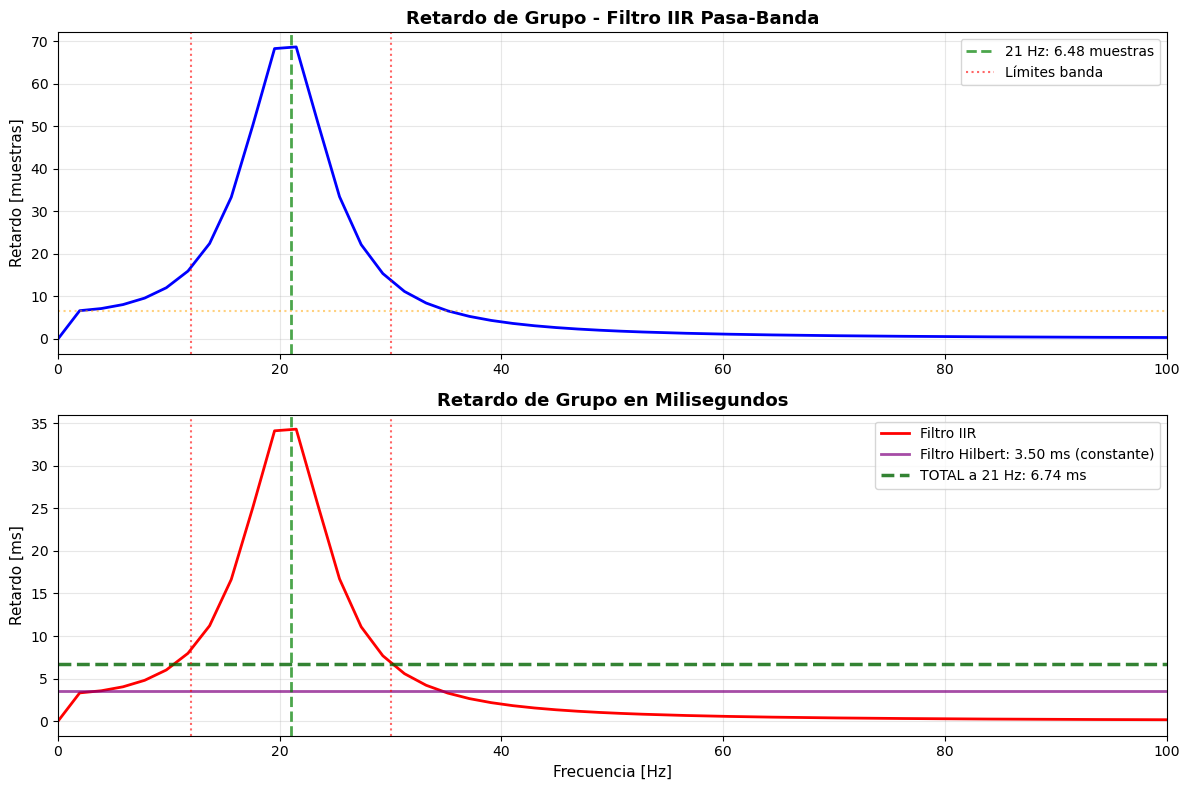


RETARDO DE GRUPO DEL SISTEMA A 21 Hz

1. FILTRO IIR PASA-BANDA:
   Retardo: 6.48 muestras = 3.24 ms

2. FILTRO DE HILBERT (FIR):
   Retardo: 7.00 muestras = 3.50 ms

3. RETARDO TOTAL (IIR + Hilbert):
   Retardo: 13.48 muestras = 6.74 ms

4. REFERENCIA:
   Período de 21 Hz: 47.62 ms
   Retardo en grados: 50.9°

----------------------------------------------------------------------
APLICACIÓN PRÁCTICA:
----------------------------------------------------------------------
Cuando tu Arduino detecta fase = 0° (pico en señal filtrada),
el pico REAL en la señal de entrada ocurrió hace:
   → 6.74 ms
   → 13.48 muestras

Para sincronizar con el pico original:
   t_pico_original = t_deteccion - 6.74 ms


In [16]:
# ==============================================================================
# CÁLCULO DE RETARDO DE GRUPO (GROUP DELAY)
# ==============================================================================
# El retardo de grupo indica cuánto se retrasa una señal al pasar por el filtro
# Es esencial para compensar y encontrar el pico real en la señal original

# 1. Retardo de grupo del filtro IIR pasa-banda
w_gd, gd_iir = signal.group_delay((b, a), fs=fs)

# 2. Retardo específico a 21 Hz (frecuencia de interés)
w_21_rad = 2 * np.pi * 21 / fs
_, gd_iir_21 = signal.group_delay((b, a), w=[w_21_rad], fs=fs)
retardo_iir_samples = gd_iir_21[0]
retardo_iir_ms = retardo_iir_samples * 1000 / fs

# 3. Retardo del filtro de Hilbert (FIR simétrico)
# Para filtros FIR simétricos, el retardo es constante: (N-1)/2
retardo_hilbert_samples = (hilbert_taps - 1) / 2
retardo_hilbert_ms = retardo_hilbert_samples * 1000 / fs

# 4. Retardo TOTAL del sistema (IIR + Hilbert)
retardo_total_samples = retardo_iir_samples + retardo_hilbert_samples
retardo_total_ms = retardo_total_samples * 1000 / fs

# Calcular período de la señal de 21 Hz para referencia
periodo_21hz_ms = 1000 / 21  # milisegundos

# ==============================================================================
# VISUALIZACIÓN DEL RETARDO DE GRUPO
# ==============================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Retardo de grupo del filtro IIR
ax1.plot(w_gd, gd_iir, 'b-', linewidth=2)
ax1.axvline(21, color='g', linestyle='--', alpha=0.7, linewidth=2, label=f'21 Hz: {retardo_iir_samples:.2f} muestras')
ax1.axhline(retardo_iir_samples, color='orange', linestyle=':', alpha=0.5)
ax1.axvline(12, color='r', linestyle=':', alpha=0.6, linewidth=1.5, label='Límites banda')
ax1.axvline(30, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax1.set_ylabel('Retardo [muestras]', fontsize=11)
ax1.set_title('Retardo de Grupo - Filtro IIR Pasa-Banda', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize=10)
ax1.set_xlim([0, 100])

# Retardo de grupo en milisegundos
gd_iir_ms = gd_iir * 1000 / fs
ax2.plot(w_gd, gd_iir_ms, 'r-', linewidth=2, label='Filtro IIR')
ax2.axhline(retardo_hilbert_ms, color='purple', linestyle='-', linewidth=2, alpha=0.7, label=f'Filtro Hilbert: {retardo_hilbert_ms:.2f} ms (constante)')
ax2.axhline(retardo_total_ms, color='darkgreen', linestyle='--', linewidth=2.5, alpha=0.8, label=f'TOTAL a 21 Hz: {retardo_total_ms:.2f} ms')
ax2.axvline(21, color='g', linestyle='--', alpha=0.7, linewidth=2)
ax2.axvline(12, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax2.axvline(30, color='r', linestyle=':', alpha=0.6, linewidth=1.5)
ax2.set_xlabel('Frecuencia [Hz]', fontsize=11)
ax2.set_ylabel('Retardo [ms]', fontsize=11)
ax2.set_title('Retardo de Grupo en Milisegundos', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_xlim([0, 100])

plt.tight_layout()
plt.show()

# ==============================================================================
# RESULTADOS - RETARDO DEL SISTEMA
# ==============================================================================
print("\n" + "=" * 70)
print("RETARDO DE GRUPO DEL SISTEMA A 21 Hz")
print("=" * 70)
print(f"\n1. FILTRO IIR PASA-BANDA:")
print(f"   Retardo: {retardo_iir_samples:.2f} muestras = {retardo_iir_ms:.2f} ms")

print(f"\n2. FILTRO DE HILBERT (FIR):")
print(f"   Retardo: {retardo_hilbert_samples:.2f} muestras = {retardo_hilbert_ms:.2f} ms")

print(f"\n3. RETARDO TOTAL (IIR + Hilbert):")
print(f"   Retardo: {retardo_total_samples:.2f} muestras = {retardo_total_ms:.2f} ms")

print(f"\n4. REFERENCIA:")
print(f"   Período de 21 Hz: {periodo_21hz_ms:.2f} ms")
print(f"   Retardo en grados: {(retardo_total_ms / periodo_21hz_ms) * 360:.1f}°")

print("\n" + "-" * 70)
print("APLICACIÓN PRÁCTICA:")
print("-" * 70)
print(f"Cuando tu Arduino detecta fase = 0° (pico en señal filtrada),")
print(f"el pico REAL en la señal de entrada ocurrió hace:")
print(f"   → {retardo_total_ms:.2f} ms")
print(f"   → {retardo_total_samples:.2f} muestras")
print(f"\nPara sincronizar con el pico original:")
print(f"   t_pico_original = t_deteccion - {retardo_total_ms:.2f} ms")
print("=" * 70)

## Demostración Práctica: Detección del Pico Original

Esta simulación muestra cómo usar el retardo calculado para encontrar el pico real en la señal de entrada cuando el sistema detecta fase = 0°.

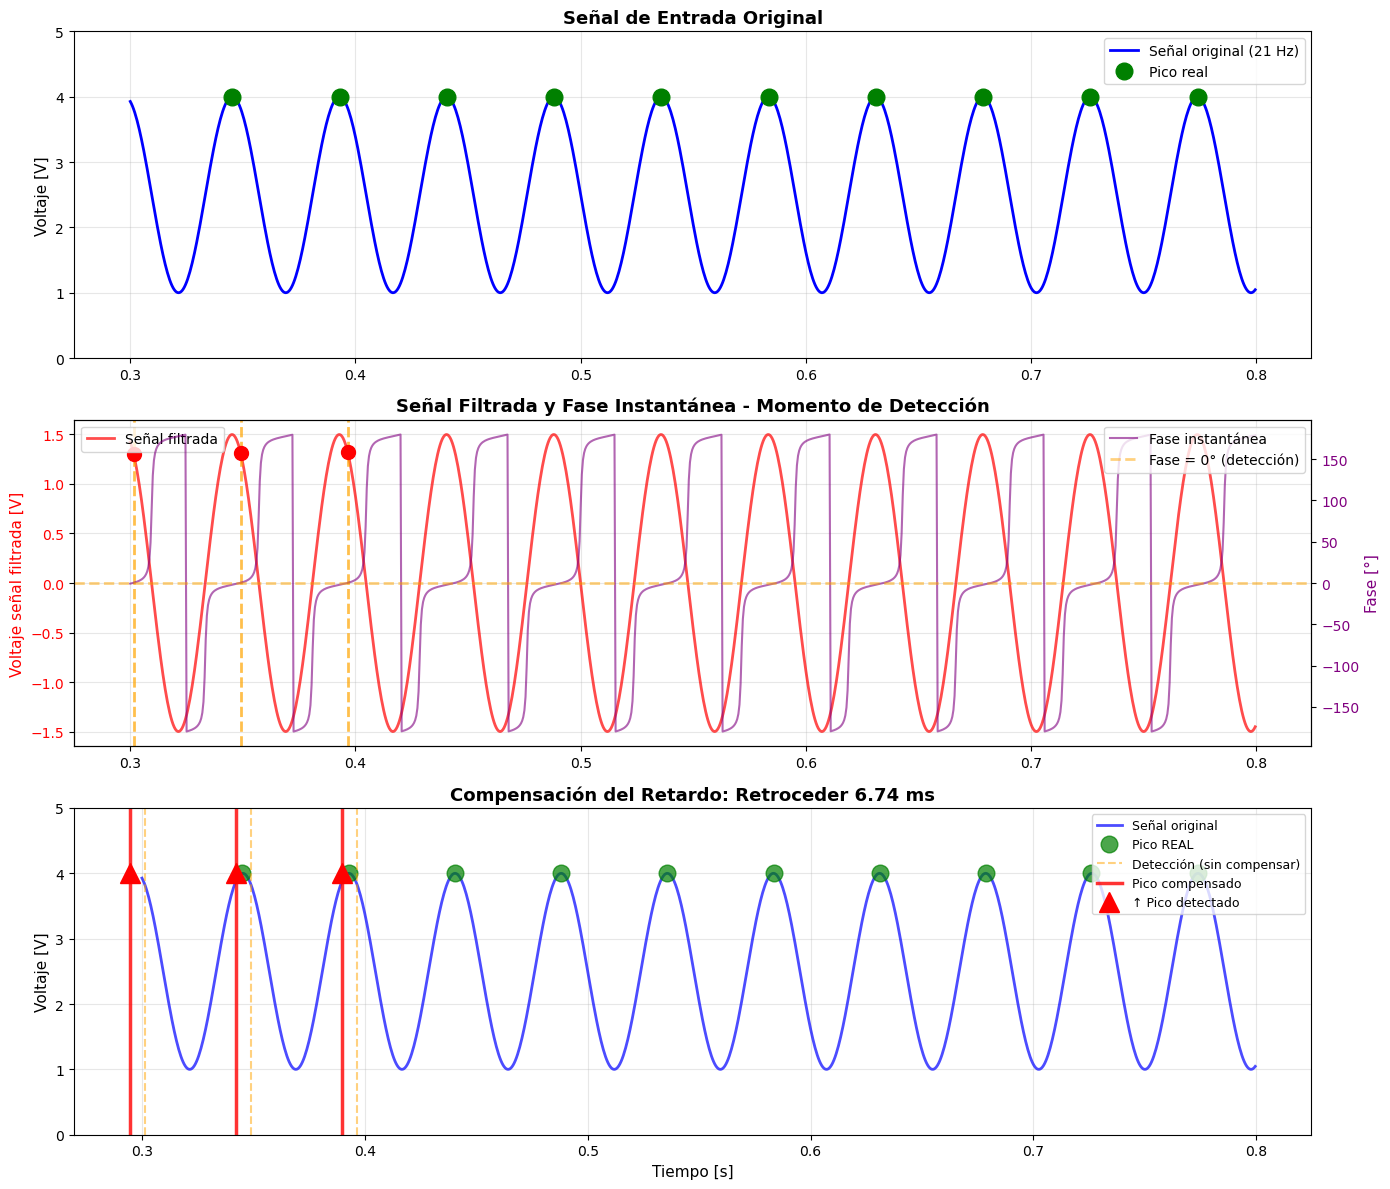


ANÁLISIS DE PRECISIÓN DE LA COMPENSACIÓN

Picos reales encontrados: 14
Detecciones de fase=0°: 3

Detección #1:
  Tiempo detección (sin compensar): 301.50 ms
  Tiempo compensado:                 294.76 ms
  Tiempo pico real:                  345.00 ms
  Error:                             -50.238 ms (-379.8°)

Detección #2:
  Tiempo detección (sin compensar): 349.00 ms
  Tiempo compensado:                 342.26 ms
  Tiempo pico real:                  345.00 ms
  Error:                             -2.738 ms (-20.7°)

Detección #3:
  Tiempo detección (sin compensar): 396.50 ms
  Tiempo compensado:                 389.76 ms
  Tiempo pico real:                  393.00 ms
  Error:                             -3.238 ms (-24.5°)

----------------------------------------------------------------------
Error promedio: 18.738 ms
Error máximo:   50.238 ms
Desv. estándar: 22.275 ms


In [17]:
# ==============================================================================
# DEMOSTRACIÓN: COMPENSACIÓN DEL RETARDO PARA ENCONTRAR EL PICO ORIGINAL
# ==============================================================================

# Crear señal de prueba: 21 Hz pura con offset DC
duration_test = 1.0
t_test = np.arange(0, duration_test, 1/fs)
signal_test_input = 1.5 * np.sin(2 * np.pi * 21 * t_test) + 2.5

# Aplicar cadena de procesamiento completa
signal_test_iir = signal.lfilter(b, a, signal_test_input)
signal_test_hilbert = signal.lfilter(hilbert_coeffs_float, 1, signal_test_iir)

# Remover DC para calcular fase
signal_test_iir_ac = signal_test_iir - np.mean(signal_test_iir)
signal_test_hilbert_ac = signal_test_hilbert - np.mean(signal_test_hilbert)

# Calcular fase instantánea
phase_test = np.arctan2(signal_test_hilbert_ac, signal_test_iir_ac)
phase_test_deg = np.rad2deg(phase_test)

# Encontrar cruces por cero de fase (picos detectados en señal filtrada)
# Buscar donde la fase cruza de negativo a positivo cerca de 0°
zero_crossings = []
threshold_phase = 5  # grados de tolerancia

for i in range(1, len(phase_test_deg)):
    if abs(phase_test_deg[i]) < threshold_phase and phase_test_deg[i-1] < 0 < phase_test_deg[i]:
        zero_crossings.append(i)

# Evitar transitorios iniciales (primeros 300ms)
zero_crossings = [idx for idx in zero_crossings if idx > int(0.3 * fs)]

# Tomar solo los primeros 3 picos detectados para la visualización
zero_crossings = zero_crossings[:3]

# ==============================================================================
# VISUALIZACIÓN
# ==============================================================================
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Región de interés (después de transitorios)
t_start = 0.3
t_end = 0.8
idx_start = int(t_start * fs)
idx_end = int(t_end * fs)

# 1. Señal de entrada original
axes[0].plot(t_test[idx_start:idx_end], signal_test_input[idx_start:idx_end], 'b-', linewidth=2, label='Señal original (21 Hz)')
# Marcar picos reales en la entrada
peaks_input, _ = signal.find_peaks(signal_test_input[idx_start:idx_end], height=3.5)
for peak_idx in peaks_input:
    axes[0].plot(t_test[idx_start + peak_idx], signal_test_input[idx_start + peak_idx], 'go', markersize=12, label='Pico real' if peak_idx == peaks_input[0] else '')
axes[0].set_ylabel('Voltaje [V]', fontsize=11)
axes[0].set_title('Señal de Entrada Original', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 5])

# 2. Señal filtrada y fase
ax2_twin = axes[1].twinx()
axes[1].plot(t_test[idx_start:idx_end], signal_test_iir[idx_start:idx_end], 'r-', linewidth=2, alpha=0.7, label='Señal filtrada')
ax2_twin.plot(t_test[idx_start:idx_end], phase_test_deg[idx_start:idx_end], 'purple', linewidth=1.5, alpha=0.6, label='Fase instantánea')
ax2_twin.axhline(0, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Fase = 0° (detección)')

# Marcar detecciones de pico (fase = 0°)
for zc_idx in zero_crossings:
    if idx_start <= zc_idx < idx_end:
        axes[1].axvline(t_test[zc_idx], color='orange', linestyle='--', alpha=0.7, linewidth=2)
        axes[1].plot(t_test[zc_idx], signal_test_iir[zc_idx], 'ro', markersize=10)

axes[1].set_ylabel('Voltaje señal filtrada [V]', fontsize=11, color='r')
ax2_twin.set_ylabel('Fase [°]', fontsize=11, color='purple')
axes[1].set_title('Señal Filtrada y Fase Instantánea - Momento de Detección', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='y', labelcolor='r')
ax2_twin.tick_params(axis='y', labelcolor='purple')
axes[1].legend(loc='upper left', fontsize=10)
ax2_twin.legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# 3. Comparación: entrada con marcadores de detección compensados
axes[2].plot(t_test[idx_start:idx_end], signal_test_input[idx_start:idx_end], 'b-', linewidth=2, alpha=0.7, label='Señal original')

# Marcar picos reales
for peak_idx in peaks_input:
    axes[2].plot(t_test[idx_start + peak_idx], signal_test_input[idx_start + peak_idx], 'go', markersize=12, alpha=0.7, label='Pico REAL' if peak_idx == peaks_input[0] else '')

# Marcar momento de detección (sin compensar)
for zc_idx in zero_crossings:
    if idx_start <= zc_idx < idx_end:
        axes[2].axvline(t_test[zc_idx], color='orange', linestyle='--', alpha=0.5, linewidth=1.5, label='Detección (sin compensar)' if zc_idx == zero_crossings[0] else '')
        
        # Compensar retardo para encontrar pico original
        t_compensated = t_test[zc_idx] - (retardo_total_ms / 1000)
        axes[2].axvline(t_compensated, color='red', linestyle='-', alpha=0.8, linewidth=2.5, label='Pico compensado' if zc_idx == zero_crossings[0] else '')
        axes[2].plot(t_compensated, 4.0, 'r^', markersize=15, label='↑ Pico detectado' if zc_idx == zero_crossings[0] else '')

axes[2].set_xlabel('Tiempo [s]', fontsize=11)
axes[2].set_ylabel('Voltaje [V]', fontsize=11)
axes[2].set_title(f'Compensación del Retardo: Retroceder {retardo_total_ms:.2f} ms', fontsize=13, fontweight='bold')
axes[2].legend(loc='upper right', fontsize=9)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 5])

plt.tight_layout()
plt.show()

# ==============================================================================
# ANÁLISIS DE PRECISIÓN
# ==============================================================================
if len(zero_crossings) > 0:
    print("\n" + "=" * 70)
    print("ANÁLISIS DE PRECISIÓN DE LA COMPENSACIÓN")
    print("=" * 70)
    
    # Encontrar picos reales en toda la señal
    peaks_real, _ = signal.find_peaks(signal_test_input, height=3.5)
    peaks_real = [p for p in peaks_real if p > int(0.3 * fs)]  # Evitar transitorios
    
    if len(peaks_real) > 0:
        print(f"\nPicos reales encontrados: {len(peaks_real)}")
        print(f"Detecciones de fase=0°: {len(zero_crossings)}")
        
        # Para cada detección, encontrar el pico real más cercano
        errors_ms = []
        for i, zc_idx in enumerate(zero_crossings[:min(3, len(zero_crossings))]):
            # Tiempo de detección compensado
            t_detected_compensated = t_test[zc_idx] - (retardo_total_ms / 1000)
            
            # Encontrar pico real más cercano
            closest_peak = min(peaks_real, key=lambda p: abs(t_test[p] - t_detected_compensated))
            t_peak_real = t_test[closest_peak]
            
            error_ms = (t_detected_compensated - t_peak_real) * 1000
            errors_ms.append(error_ms)
            
            print(f"\nDetección #{i+1}:")
            print(f"  Tiempo detección (sin compensar): {t_test[zc_idx]*1000:.2f} ms")
            print(f"  Tiempo compensado:                 {t_detected_compensated*1000:.2f} ms")
            print(f"  Tiempo pico real:                  {t_peak_real*1000:.2f} ms")
            print(f"  Error:                             {error_ms:.3f} ms ({error_ms*21/1000*360:.1f}°)")
        
        if len(errors_ms) > 0:
            print(f"\n" + "-" * 70)
            print(f"Error promedio: {np.mean(np.abs(errors_ms)):.3f} ms")
            print(f"Error máximo:   {np.max(np.abs(errors_ms)):.3f} ms")
            print(f"Desv. estándar: {np.std(errors_ms):.3f} ms")
    
    print("=" * 70)
else:
    print("\nNo se detectaron cruces de fase en la región estable.")

# Resumen de la Arquitectura del Sistema

## Flujo de Procesamiento de Señal

```
Entrada ADC (A0)  →  Filtro IIR Pasa-Banda  →  Filtro Hilbert  →  CORDIC  →  Detección  →  Pulso (Pin 10)
   (2000 Hz)            (21 Hz ± 9 Hz)         (Desfase 90°)   (Mag+Fase)   (Umbrales)     (2 ms)
```

## Decisiones de Diseño y Justificaciones

### 1. Frecuencia de Muestreo: 2000 Hz
- **Elección:** Timer2 configurado para disparar el ADC a 2000 Hz (OCR2A = 124, prescaler = 64)
- **Justificación:**
  - Nyquist: 2000 Hz permite capturar señales hasta 1000 Hz sin aliasing
  - Para señal de 21 Hz: 2000/21 ≈ 95 muestras por ciclo (excelente resolución)
  - Balance entre precisión temporal y carga del microcontrolador
  - Permite procesar cada muestra en ~500 μs

### 2. Filtro IIR Pasa-Banda (21 Hz ± 9 Hz, Q=2.333)
- **Elección:** Biquad IIR con banda 12-30 Hz, centrado en 21 Hz
- **Justificación:**
  - **Selectividad:** Rechaza componentes DC, 50 Hz (red eléctrica), y alta frecuencia
  - **Q moderado (2.333):** Evita resonancias excesivas que introducirían sobrepaso (ringing)
  - **Eficiencia:** IIR de 2º orden requiere solo 5 coeficientes y 4 estados
  - **Formato Q15:** Precisión suficiente (15 bits fraccionarios) para aritmética entera de 32 bits

### 3. Filtro de Hilbert FIR (15 taps)
- **Elección:** FIR antisimétrico de 15 coeficientes
- **Justificación:**
  - **Transformada analítica:** Genera componente en cuadratura (I/Q) para calcular envolvente y fase
  - **15 taps:** Compromiso entre precisión del desfase de 90° y memoria (30 bytes)
  - **Retardo constante:** (N-1)/2 = 7 muestras = 3.5 ms (predecible para compensación)
  - **Simetría:** Coeficientes pares = 0 (ahorra computación)

### 4. Algoritmo CORDIC
- **Elección:** CORDIC vectorial de 16 iteraciones para magnitud y fase
- **Justificación:**
  - **Sin división ni raíz cuadrada:** Implementable en enteros (crítico para Arduino)
  - **Precisión:** 16 iteraciones dan ~15 bits de precisión
  - **Eficiencia:** Solo sumas, restas y desplazamientos (shifts)
  - **Rango completo:** Fase de -180° a +180° (±32768 en representación)

### 5. Umbrales de Detección
- **MAGNITUDE_THRESHOLD = 50 << 15:**
  - Evita falsos positivos por ruido de baja amplitud
  - Valor ajustado experimentalmente según SNR esperado
  
- **PHASE_THRESHOLD = 2730 (≈ ±15°):**
  - Detecta fase ≈ ±180° (picos negativos de la señal)
  - Ventana de ±15° tolera variaciones por ruido de fase
  - Evita detecciones múltiples por jitter

### 6. Estrategia de Predicción
- **Retardo de filtros:** 10 ms (estimado para IIR + Hilbert)
- **Período de 21 Hz:** 48 ms
- **Predicción:** Detectar pico, esperar (48 - 10) = 38 ms hasta el siguiente
- **Justificación:**
  - No intenta compensar el retardo retroactivamente (imposible en tiempo real)
  - En su lugar, predice el **siguiente** pico usando periodicidad conocida
  - PREDICTION_DELAY_SAMPLES = 38 ms × 2 = 76 muestras

### 7. Período Refractario: 20 muestras (10 ms)
- **Justificación:**
  - Evita múltiples detecciones del mismo pico por ruido
  - 10 ms < 48 ms (período), permite detectar picos consecutivos
  - Protege contra rebotes en la condición de fase

### 8. Cola de Pulsos (PULSE_QUEUE_SIZE = 4)
- **Justificación:**
  - Gestiona ráfagas de detecciones sin perder eventos
  - Cada entrada almacena contador de muestras hasta disparar el pulso
  - Implementación circular eficiente (head/tail/count)

## Flujo de Operación en Tiempo Real

1. **ISR Timer2 (cada 0.5 ms):** Dispara conversión ADC
2. **ISR ADC (cuando termina):** Guarda muestra y activa flag `newSampleReady`
3. **Loop principal (cuando `newSampleReady`):**
   - Aplica filtro IIR pasa-banda
   - Aplica filtro de Hilbert
   - Calcula magnitud y fase con CORDIC
   - Evalúa condiciones de pico (magnitud Y fase)
   - Si hay pico y no está en período refractario:
     - Encola pulso con retardo de 76 muestras
     - Activa período refractario
   - Decrementa contadores de cola de pulsos
   - Dispara pulso de 2 ms cuando contador llega a 0
   - Genera salida PWM con señal filtrada (para monitoreo)

## Valores Clave del Código Actual (main.cpp)

| Parámetro | Valor | Ubicación en código |
|-----------|-------|---------------------|
| Frecuencia de muestreo | 2000 Hz | setupTimer2(), OCR2A=124 |
| Filtro IIR b0 | 456 (Q15) | línea 15 |
| Filtro IIR b1 | 0 (Q15) | línea 16 |
| Filtro IIR b2 | -456 (Q15) | línea 17 |
| Filtro IIR a1 | -64482 (Q15) | línea 18 |
| Filtro IIR a2 | 31855 (Q15) | línea 19 |
| Hilbert taps | 15 | línea 27 |
| Hilbert coefs | [-328, 0, -984, ...] | líneas 28-30 |
| MAGNITUDE_THRESHOLD | 50 << 15 | línea 36 |
| PHASE_THRESHOLD | 2730 | línea 37 |
| PERIOD_21HZ_MS | 48 | línea 38 |
| FILTER_DELAY_MS | 10 | línea 39 |
| PREDICTION_DELAY_MS | 38 | línea 41 |
| PREDICTION_DELAY_SAMPLES | 76 | línea 42 |
| PULSE_DURATION | 2 ms | línea 47 |
| Período refractario | 20 muestras | línea 263 |

## Próximos Pasos para Optimización

1. **Ajuste fino de FILTER_DELAY_MS:** Usar análisis de retardo de grupo del notebook para valor más preciso
2. **Calibración de umbrales:** Ajustar MAGNITUDE_THRESHOLD según amplitud real de la señal
3. **Verificación experimental:** Comparar tiempos de pulso con osciloscopio vs señal original
4. **Adaptación a variaciones:** Considerar detección de frecuencia variable si la señal no es exactamente 21 Hz